# Lab 5 Part 2: Digital Communication with Audio Frequency Shift Keying (AFSK)

In this part of the lab we are going to experiment with digital modulation and communication. Network Communication systems have layered architecture. The bottom layer is the physical which implements the modulation. Here we will use [AFSK](http://en.wikipedia.org/wiki/Frequency-shift_keying), which is a form of BFSK in the audio range (hence the 'A').  We will write a modulator/demodulator for AFSK.  In the next part of lab we will leverage [AX.25](http://www.tapr.org/pub_ax25.html), which is an amateur-radio data-link layer protocol. [AX.25](http://www.tapr.org/pub_ax25.html) is a packet based protocol that will help us transmit data using packets. It implements basic synchronization, addressing, data encapsulation and some error detection.  In the ham world, an implementation of AFSK and [AX.25](http://www.tapr.org/pub_ax25.html)  together is also called a [TNC ( Terminal Node Controller )](http://en.wikipedia.org/wiki/Terminal_node_controller). In the past TNC's were separate boxes that hams used to attach to their radios to communicate with packet-based-communication. Today, it is easy to implement TNC's in software using the computer's soundcard.... as you will see here! 




In [1377]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import bitarray, time, urllib, ssl
from scipy import signal, integrate
from fractions import gcd
from __future__ import division
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [1433]:
# function to compute least common multipler
def lcm(numbers):
    return reduce(lambda x, y: (x*y)/gcd(x,y), numbers, 1)

# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = floor(len(x)/N)
    x_ = reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return r_[-N/2.0:N/2.0]/N*fs, mean(abs(X)**2,axis=0)

## AFSK1200, or Bell 202 modem

AFSK1200 encodes digital binary data at a data-rate of 1200b/s. 

## It uses the frequencies 1200Hz and 2200Hz ( center frequency of $1700$Hz $\pm 500$ Hz) to encode the '0's and '1's (also known as space and mark) bits.  

Even though it has a relatively low bit-rate it is still the dominant standard for amateure packet radio over VHF. It is a common physical layer for the AX.25 packet protocol and hence a physical layer for the  Automatic Packet Reporting System (APRS),  which we will describe later. 

The exact analytic frequency spectrum of a general FSK signal is difficult to obtain. But, when the mark and space frequency difference $\Delta f$ is much larger than the bit-rate, $B$,  then the bandwidth of FSK is approximately $2\Delta f + B$. This is not exactly the case for AFSK1200 where the spacing between the frequencies is 1000Hz and the bit-rate is 1200 baud.

<center><img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/lab3/AFSK.png" alt="AFSK" style="width: 350px;"/></center>
<center>Figure 1: Approximate spectrum of AFSK</center>

Note, that for the (poor) choice of 1200/2200Hz for frequencies, a synchronous phase (starting each bit with the same phase) is not going to be continuous. For the Bandwidth to be narrow, it is important that the phase in the modulated signal is continuous. For this reason, AFSK1200 has to be generated in the following way:
$$ s(t) = cos\left(2\pi f_c t + 2\pi \Delta f \int_{\infty}^t m(\tau)d\tau \right),$$
where $m(t)$ has the value =1 for a duration of a mark bit, and a value =-1 for a duration of a space bit. Such $m(t)$ signal is called an Non-Return-to-Zero (NRZ) signal in the digital communication jargon.  Here's a link to some [notes](http://www.dip.ee.uct.ac.za/~nicolls/lectures/eee482f/13_fsk_2up.pdf) provided by Fred Nicolls from the university of Cape Town.

The integration guarentees that the phase is continuous. In addition, the instantaneous frequency of $s(t)$ is the derivative of its phase, $2\pi f_c + 2\pi \Delta f m(t)$, which is exactly what we need. 

#### Taks 1

* Write a function `sig = afsk1200(bits,fs)` the function will take a bitarray (bitarray is a python module for storing array of bits) of bits, and a sampling rate.  It will output an AFSK1200 modulated signal of them, sampled at fs [Hz]. 

## **Note that Mark frequency is 1200Hz and Space Frequency is 2200Hz**. 

* Note, that when `fs` does not divide by 1200, each "bit" will have non-integer length in samples. If you are not careful, this would lead to deviation from the right rate over time. To make sure that you produce signals that have the right rate over time generate the signal first at a rate of `lcm((1200,fs))`, the least common multiplier (which does divide by 1200) for the entire bit sequence and then downsample by the right value at the end. You don't necessarily need to low-pass filter, since the signal is narrow banded anyways. 

* For integration, use the function `integrate.cumtrapz`, which implements the trapezoid method. (don't forget multiplying with the $d\tau$)

In [1434]:
def int2bitarray(intarray):
    # converts an array of integers type uint8 and returns an equivalent Python bitarray.bitarray
    bits = ''
    for num in intarray:
        bits += np.binary_repr(num,width=8)
    bits = bitarray.bitarray(bits)
    return bits

def bits2nparray(bits):
     # converts {0,1}^n bitarray to np array
    return (np.fromstring((str(bits)[10:-2]),'u1') - ord('0')).astype(np.float)

In [1435]:
def afsk1200(bits, fs = 48000):
    #
    # data encoded at a data-rate of 1200b/s
    #
    # m(t) has value has value = 1 for a duration of a mark (@1200Hz) bit, and -1 for the duration of a space (@2200Hz) bit.
    #
    #
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at fs.
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal

    bits = -2*bits2nparray(bits) + 1 # want -1, +1 bits
    bit_period = 1/1200
    fc = 1700
    df = 500
    temp_rate = lcm((1200,fs)) # first generate signal at a higher frequency than fs s.t. it is a multiple of 1200.
    repeat_bit = int(temp_rate*bit_period)
    bits = np.hstack([ [b]*repeat_bit for b in bits ]) # bitrate is 1200b/s, so make each bit last for 1/1200 s.
    
    integral = integrate.cumtrapz(fc + df*bits) # integral of constant dt = t*constant.
    sig = np.cos( 2*np.pi*integral/temp_rate )
    sig = sig[::int(temp_rate/fs)] #  downsample

    return sig

To help you debug, we generated a sequence of 4096 bits and its AFSK1200 encoded signals at sampling-rates of 8192Hz, 11025Hz, 44100Hz and 48000Hz. Compare the result of your function and make sure they match well. We assume that the phase at n=0 is zero (i.e., cosine modulation). Use the following code to load the data: 

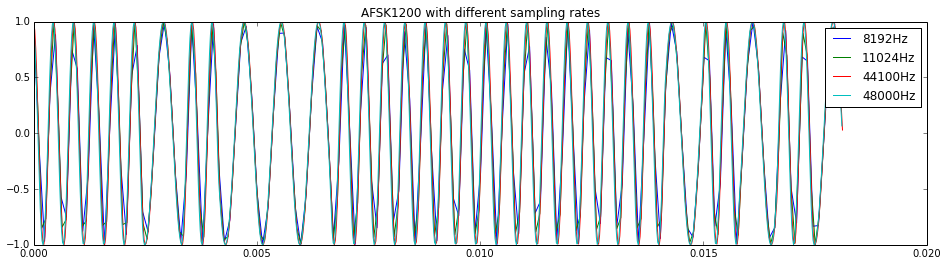

In [1436]:
# ------------- code we used to generate the bitstream and the signals ------------------
# bits_ref=bitarray.bitarray((rand(4096)>0.5).tolist())
# sig_ref8192 = afsk1200(bits_ref,fs = 8192)
#sig_ref11025 = afsk1200(bits_ref,fs = 11025)
#sig_ref44100 = afsk1200(bits_ref,fs = 44100)
#sig_ref48000 = afsk1200(bits_ref,fs = 48000)
#np.savez_compressed('debug_ref.npz', bits=bits_ref, sig_ref8192=sig_ref8192, sig_ref11025 = sig_ref11025,sig_ref44100=sig_ref44100, sig_ref48000=sig_ref48000)


# Load the file from the class website
# testfile = urllib.URLopener()
# testfile.context = ssl._create_unverified_context()
# testfile.retrieve("https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab5/debug_ref.npz", 'debug_ref.npz')

testnpz = np.load('debug_ref.npz')
bits_ref = testnpz['bits']
sig_ref8192 = testnpz['sig_ref8192']
sig_ref11025 = testnpz['sig_ref11025']
sig_ref44100 = testnpz['sig_ref44100']
sig_ref48000 = testnpz['sig_ref48000']

# Check that all the loaded signals align
fig = figure(figsize(16,4))
plt.plot(r_[0.0:148]/8192,sig_ref8192[:148])
plt.plot(r_[0.0:200]/11025,sig_ref11025[:200])
plt.plot(r_[0.0:800]/44100,sig_ref44100[:800])
plt.plot(r_[0.0:870]/48000,sig_ref48000[:870])
plt.title('AFSK1200 with different sampling rates')
plt.legend(('8192Hz','11024Hz','44100Hz', '48000Hz'))


#### Task2 :

Apply your function on the bitstream above with the different sampling rate. Validate that they match well:


In [1437]:
loaded_bits = int2bitarray(bits_ref)

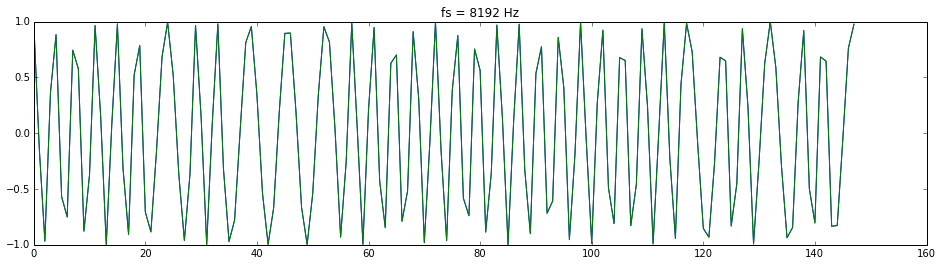

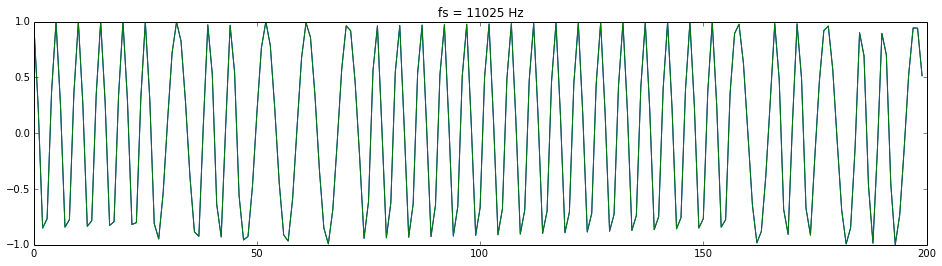

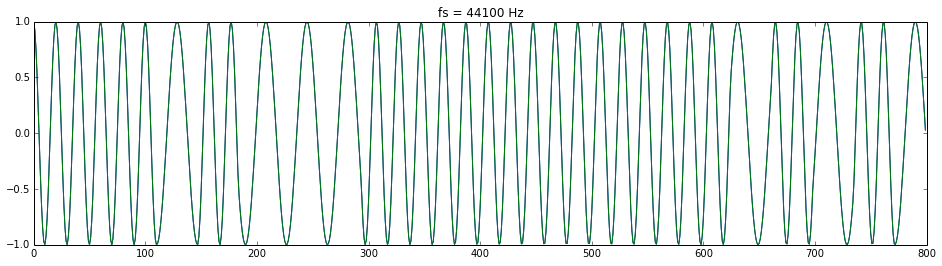

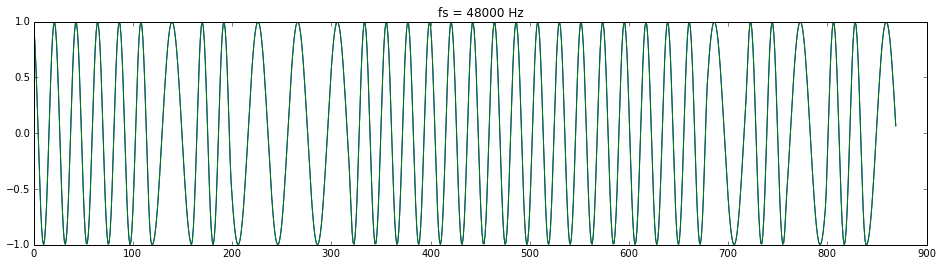

In [1438]:
# Validation code
s = afsk1200(loaded_bits, fs = 8192)
plt.figure()
plt.title('fs = 8192 Hz')
plt.plot(s[:148])
plt.plot(sig_ref8192[:148])

s = afsk1200(loaded_bits, fs = 11025)
plt.figure()
plt.title('fs = 11025 Hz')
plt.plot(s[:200])
plt.plot(sig_ref11025[:200])

s = afsk1200(loaded_bits, fs = 44100)
plt.figure()
plt.title('fs = 44100 Hz')
plt.plot(s[:800])
plt.plot(sig_ref44100[:800])

s = afsk1200(loaded_bits, fs = 48000)
plt.figure()
plt.title('fs = 48000 Hz')
plt.plot(s[:870])
plt.plot(sig_ref48000[:870])

### Spectrum of AFSK1200

We will now generate an AFSK modulated signal and compute its spectrum

#### Task 3:
* Generate a new sequence of 4096 random bits with equal probability, using the code     `bitarray.bitarray((rand(4096)>0.5).tolist())` 
* Generate the AFSK1200 signal at 48KHz 
* Compute the average power-spectrum with a spectral resolution of 10Hz (What's the window size?)
* Display the result between 0 and 3KHz, using the command `plt.axis`
* Does the spectrum looks like the one in Figure 2?



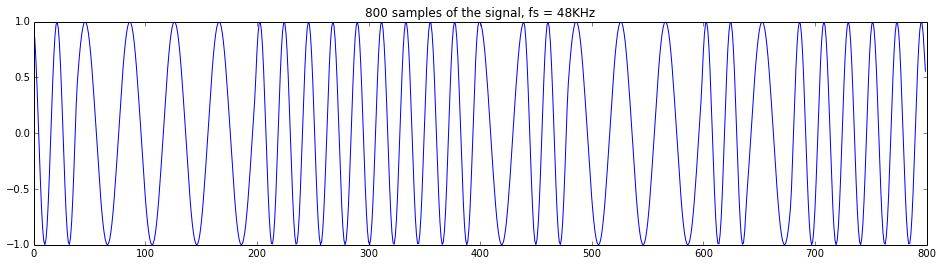

In [1439]:
fs = 48000
bits = bitarray.bitarray((rand(4096)>0.5).tolist())

# Your code here
sig = afsk1200(bits, fs=48e3)
plt.figure()
plt.title('800 samples of the signal, fs = 48KHz')
plt.plot(sig[:800])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


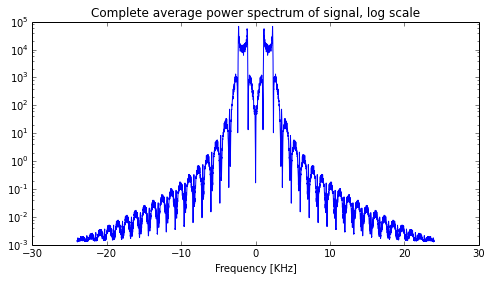

In [1442]:
window_size = 48e3/10
f, spec = avgPS(sig, N=window_size, fs=48e3)

fig = figure(figsize=(8,4))
title('Complete average power spectrum of signal, log scale')
yscale('log')
xlabel('Frequency [KHz]')
plot(f/1e3,spec)

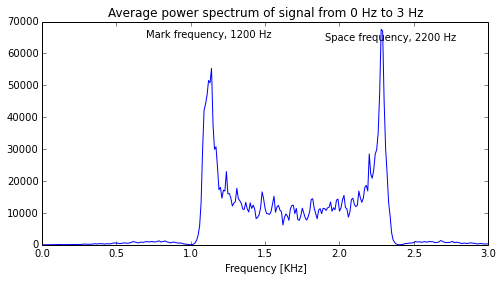

In [1443]:
fig = figure(figsize=(8,4))
title('Average power spectrum of signal from 0 Hz to 3 Hz')
xlabel('Frequency [KHz]')
axis(xmin = 0, xmax = 3)
annotate('Mark frequency, 1200 Hz', xy=(2, 1), xytext=(0.7, 6.5e4))
annotate('Space frequency, 2200 Hz', xy=(2, 1), xytext=(1.9, 6.4e4))
plot(f/1e3,spec)

## AFSK1200 demodulation
AFSK is a form of digital frequency modulation. As such, it can be demodulated like FM. However, this is not the best way to compute it in practice. 

## For example, any tone interference between the mark and space frequency will break the demodulation.  {question: why is this?}

Because AFSK alternates between two frequencies, 
## we can place two bandpass filters around the frequency of the Mark and Space and use envelope detection to determine which frequency is active in a bit period.

This is called a non-coherent AFSK demodulation, because the receiver phase does not need to be synced to the transmitter phase in order to demodulate the signal. The implementation we will use here is loosely based on on the one by Sivan Toledo (4X6IZ), a CS faculty in Tel-Aviv university who has written a nice article on a high-performance AX.25 modem, and also loosely based DireWolf, a multi-platform software TNC. You can find Sivan's article [Here](http://www.cs.tau.ac.il/~stoledo/Bib/Pubs/QEX-JulAug-2012.pdf), and Direwolf GitHub link [Here](https://github.com/wb2osz/direwolf). 


### Non-Coherent Demodulation of AFSK
Here's a diagram of a non-coherent AFSK1200 demodulator that returns an NRZ signal:
<br><br><br>
<center><img src="https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab5/AFSK_demod.png" alt="AFSK" style="width: 950px;"/></center>
<br>
<center>Figure 3: AFSK1200 non-coherent demodulator</center>


#### Task 4:

Since our audio device supports 48KHz, we will use this sampling frequency, as it divides well with 1200.
As mentioned in the article, it is recommended to bandpass filter before processing  (900-2500Hz). This filter has no theoretical benefit for the case of random gaussian noise. But it still has some advantages when the noise and interferences are non-gaussian. We will not do it now, but will implement this later when we implement our modem.

* Using signal.firwin, design a TBW=2 LP filter with a (two-sided) bandwidth of approximately 1200Hz. It's easier if you choose the number of taps to be odd. (what's the length of the filter?)
* From the LP filter gernerate two bandpass filters by complex modulating the LP filter to be centered around 1200Hz and 2200Hz respectively. 
* Filter the random stream of bits you generated previously using the two filters. **I'm assuming this means the afsk1200 signal. ** 

The absolute value of the result represents the envelope of the filtered signal. The difference between the envelopes should represent the NRZ signal. 

** So, envelope detection = |filt sig1 (mark)| - |filt sig2 (space)| ** 

* Plot the result of the envelope detection of the mark and space signals for the first 4800 samples on the same plot. Can you see how they switch?
* Compute the "analog" NRZ signal by taking the difference between the mark and space envelopes. I refer to this as "analog" since it is not purely binary.
* To implement the optional filter (Fig. 1), filter the NRZ signal, now, with a **low-pass filter**. Have the filter be the same length you used for the mark and spaces, only for its cuttoff frequency, set it to 1200*1.2 Hz. This is a balance between noise rejection and keeping the signal and helps a bit with detection in noise. 
* In a different plot, display the filtered NRZ for the first 4800 samples. Can you see the bits?


#### \*\*\* Comment: How are parameters fine tuned? 
Well... the answer is complicated. There's theory and practice. From a theory point of view, we choose the right bandwidths and signal lengths. From a practical point of view, parameters can be tuned by testing performance over simulations and real-life experiments. For example, WA8IMF created a test CD for testing AFSK1200 modems. He recorded many minutes of APRS traffic in LA. Hardware TNC can usually decode 500-600 packets on these test CD's whereas optimized software TNCs can detect over 1000. Here's a [link](http://wa8lmf.net/TNCtest/) for the CD.


In [1444]:
# # Your code here:
# # TBW = (M+1)*(omega/2pi) = 2.
# # omega = (2pi/fs)*1200*2 = 0.3414 (remember, two-sided)
# # ==> 2 = TBW = (M+1)*0.3414/2pi
# # ==> M = ciel(35.81)-1 = 36-1 = 35

# # low pass filter

# taps = 35
# lpf = signal.firwin(taps, cutoff=1200/48e3)
# figure()
# title('LPF in time, TBW = 2')
# plot(lpf)
# ft_lpf = np.fft.fftshift(np.fft.fft(lpf))
# f = r_[-taps/2.0:taps/2.0]/taps*48e3

# figure()
# title('Magnitude of LPF, TBW = 2')
# xlabel('Frequency [KHz]')
# plt.plot(f/1e3, abs(ft_lpf))

# # complex modulate to ctr around 1200 Hz and 2200 Hz

# modulator = lambda freq, t: np.exp(-2j*pi*freq*t)

# t = r_[0:taps]/48e3
# bp1200 = lpf*modulator(1200, t)
# bp2200 = lpf*modulator(2200, t)

# # figure()
# # plot(bp1200)
# # ft_bp = np.fft.fftshift(np.fft.fft(bp1200))
# # f = r_[-taps/2.0:taps/2.0]/taps*48e3

# # figure()
# # title('Magnitude of LPF, TBW = 2')
# # xlabel('Frequency [KHz]')
# # plt.plot(f/1e3, abs(ft_bp))

# mark_bits = signal.fftconvolve(sig, bp1200, 'same') # todo: should these be 'same'?
# space_bits = signal.fftconvolve(sig, bp2200, 'same')

# NRZ = abs(mark_bits) - abs(space_bits)

# figure()
# title('4800 samples of filtered NRZ signal')
# xlabel('Sample')
# plot(NRZ[:4800])

# # noise reduction: get rid of high-freq noise.

# noise_rdxn_lpf = signal.firwin(taps, cutoff=1.2*1200/48e3)
# denoised_NRZ = signal.fftconvolve(NRZ, noise_rdxn_lpf, 'same')

# figure()
# title('4800 samples of the noise-reduced (LPF) NRZ signal')
# xlabel('Sample')
# plot(denoised_NRZ[:4800])

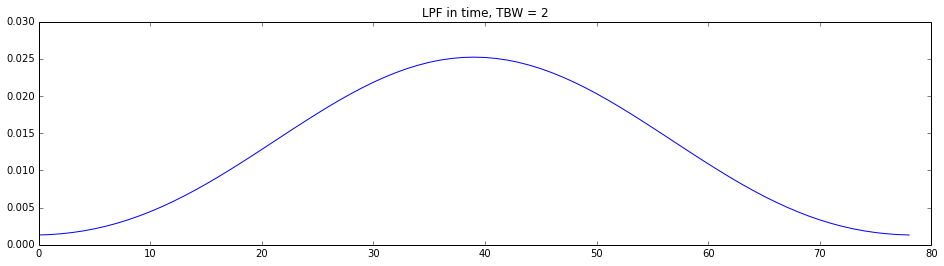

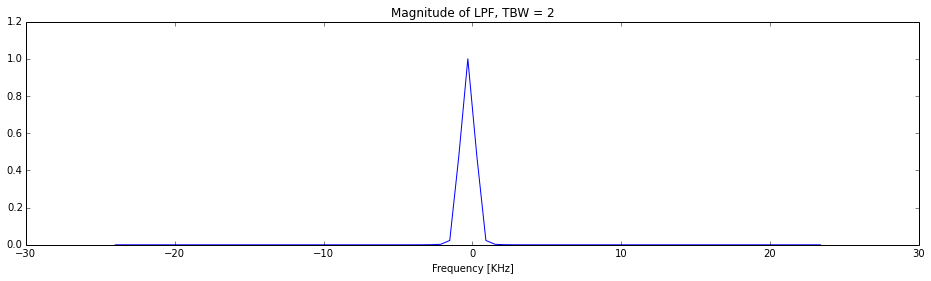

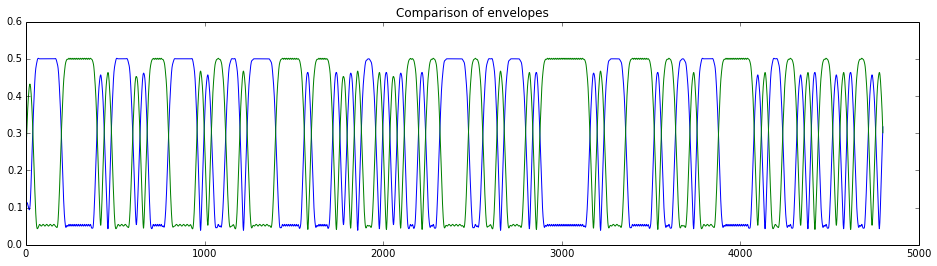

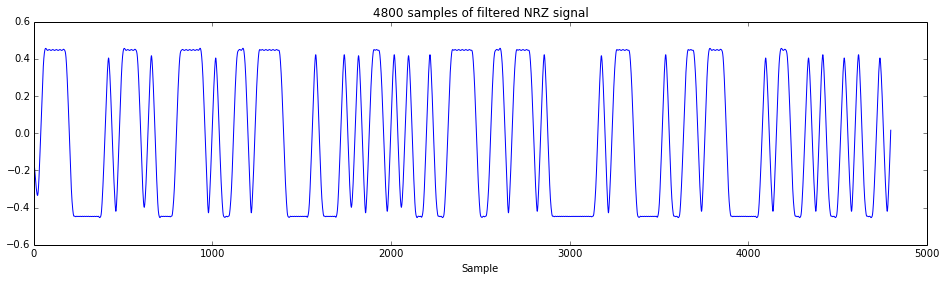

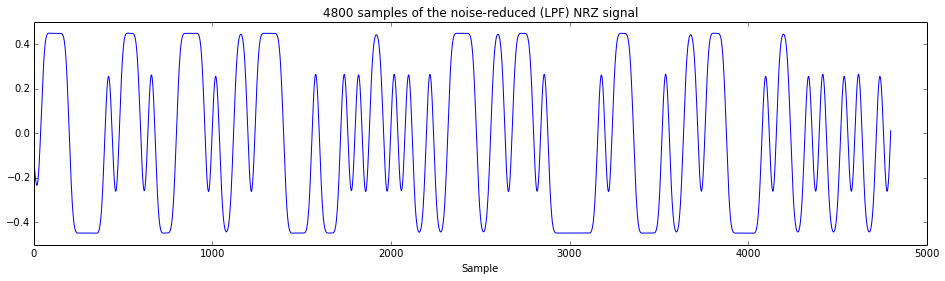

In [1456]:
# Your code here:
# TBW = (M+1)*(omega/2pi) = 2.
# omega = (2pi/fs)*1200*2 = 0.3414 (remember, two-sided)
# ==> 2 = TBW = (M+1)*0.3414/2pi
# ==> M = ciel(35.81)-1 = 36-1 = 35

# low pass filter

taps = 79
lpf = signal.firwin(taps, cutoff=600/48e3)
figure()
title('LPF in time, TBW = 2')
plot(lpf)
ft_lpf = np.fft.fftshift(np.fft.fft(lpf))
f = r_[-taps/2.0:taps/2.0]/taps*48e3

figure()
title('Magnitude of LPF, TBW = 2')
xlabel('Frequency [KHz]')
plt.plot(f/1e3, abs(ft_lpf))

# complex modulate to ctr around 1200 Hz and 2200 Hz

modulator = lambda freq, t: np.exp(-2j*pi*freq*t)

t = r_[0:taps]/48e3
bp1200 = lpf*modulator(1200, t)
bp2200 = lpf*modulator(2200, t)

# figure()
# plot(bp1200)
# ft_bp = np.fft.fftshift(np.fft.fft(bp1200))
# f = r_[-taps/2.0:taps/2.0]/taps*48e3

# figure()
# title('Magnitude of LPF, TBW = 2')
# xlabel('Frequency [KHz]')
# plt.plot(f/1e3, abs(ft_bp))

mark_bits = signal.fftconvolve(sig, bp1200, 'same') # todo: should these be 'same'?
space_bits = signal.fftconvolve(sig, bp2200, 'same')

NRZ = abs(mark_bits) - abs(space_bits)

figure()
plot(abs(mark_bits)[:4800])
plot(abs(space_bits)[:4800])
title('Comparison of envelopes')

figure()
title('4800 samples of filtered NRZ signal')
xlabel('Sample')
plot(NRZ[:4800])

# noise reduction: get rid of high-freq noise.

noise_rdxn_lpf = signal.firwin(taps, cutoff=1.2*1200/48e3)
denoised_NRZ = signal.fftconvolve(NRZ, noise_rdxn_lpf, 'same')

figure()
title('4800 samples of the noise-reduced (LPF) NRZ signal')
xlabel('Sample')
plot(denoised_NRZ[:4800])

#### Task 5:
* Extract the digital NRZ signal by computing the signum (`sign`) function of the "analog" NRZ. 
* The bit value is the value of the NRZ function in the middle of the bit period. Don't forget to compensate for the delay of the filters, or use `mode='same'` when performing filtering. Decode the bits and store them as a `bitarray` type.
* Plot 800 samples or the Digital NRZ. Overlay a stem plot on top of that at the indexes in which you sampled the bit values. Make sure as a sanity check that you actually sampled at the middle of the interval. Only show the plot for the first 20 bits
* Print the value of the first 100 decoded bits and compared to the encoded ones. Make sure they are exactly the same!


bitarray('0111100000101110100011110100110111100001000101011010100100111100110111010000000101110000100110111000')
bitarray('0111100000101110100011110100110111100001000101011010100100111100110111010000000101110000100110111000')
('Percent error across ALL bits:', 0.0, '%')


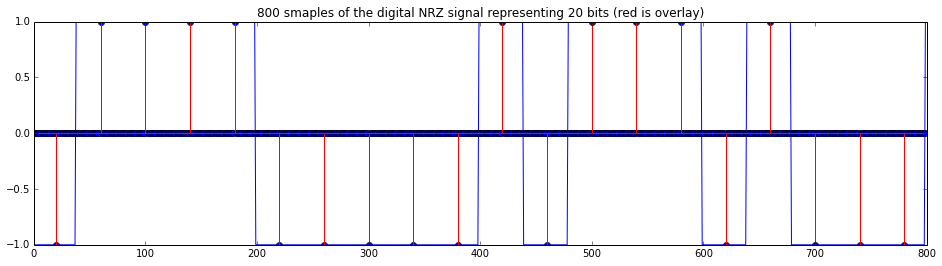

In [1446]:
# your code here:
# note: in my notebook, dig_NRZ represents the discrete signal of bits, sign_NRZ is equivalent to what is called 'digital NRZ'

baud = 1200
fs = 48e3
sign_NRZ = sign(denoised_NRZ) # equivalent to 'digital NRZ' (because it's a signal)

# fs/1200 is number of samples a bit lasts since bitrate is 1200 Hz,
# so decimate by keeping every fs/1200 = 40th sample,
# but start this at the middle of the 0th bit period, so at 20 samples in.
dig_NRZ = sign_NRZ[20::int(48e3/1200)]
figure()
title('800 smaples of the digital NRZ signal representing 20 bits (red is overlay)')
plot(sign_NRZ[:800])

overlay = np.zeros(len(sign_NRZ))[:int(fs/baud)*20]
overlay[int((fs/baud)/2)::int(fs/baud)] = sign_NRZ[:int(fs/baud)*20][int((fs/baud)/2)::int(fs/baud)]
stem(overlay, 'r')

# print the decoded bits compared to the transmitted bits

bit_dec = bitarray.bitarray((dig_NRZ>0).tolist())
print(bit_dec[:100])
print(bits[:100])
print('Percent error across ALL bits:',100*np.sum(bits2nparray(bit_dec) != bits2nparray(bits))/len(bit_dec), '%')

#### Task 6:

* Write a function NRZ = nc_afsk1200Demod(sig, fs=fs, TBW=TBW) that implements the above non-coherent demodulation and returns the "analog" NRZ (i.e. without rectifying it).

**Self-reminder: non-coherent demodulation means the receiver phase is not synched to the transmitter phase when demodulating the signal.**

In [1462]:
def nc_afsk1200Demod(sig, fs=48000.0, TBW=2.0, baud=1200.0):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 1200
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    
    # your code here
    
    # TBW calcxn kept from before, since TBW = 2
    # TBW = (M+1)*(omega/2pi) = 2.
    # omega = (2pi/fs)*1200*2 = 0.3414 (remember, two-sided)
    # ==> 2 = TBW = (M+1)*0.3414/2pi
    # ==> M = ciel(35.81)-1 = 36-1 = 35

    # low pass filter 
    
    taps = -1 + (TBW/baud)*fs
    lpf = signal.firwin(taps, cutoff=baud/(2*fs))

    # complex modulate to ctr around 1200 Hz and 2200 Hz

    modulator = lambda freq, t: np.exp(-2j*pi*freq*t)
    
    t = r_[0:taps]/fs
    bp1200 = lpf*modulator(1200, t)
    bp2200 = lpf*modulator(2200, t)

    mark_bits = signal.fftconvolve(sig, bp1200, 'same') # todo: should these be 'same'?
    space_bits = signal.fftconvolve(sig, bp2200, 'same')

    # here, abs(...) is envelope of (...). Difference of envelopes is NRZ; see figure 3.
    NRZ = abs(mark_bits) - abs(space_bits)

    # noise reduction: get rid of high-freq noise.

    noise_rdxn_lpf = signal.firwin(taps, cutoff=1.2*baud/fs)
    denoised_NRZ = signal.fftconvolve(NRZ, noise_rdxn_lpf, 'same')
    
    return denoised_NRZ

### Bit Error Rate (BER)
One way to evaluate the properties of a digital modulation scheme is to compute the bit-error-rate (BER) curves as a function of signal-to-noise ratio (SNR). 

** BER = # of bit errors (received bits that have been altered due to decoding error) / total # of transmitted bits. **

Let's calculate the BER for our AFSK demodulator:

#### Task 7:
* Generate a 10000 long random bitstream
* AFSK1200 modulate the bitstream
* Add random gaussian noise with a standard deviation of 1 to the afsk signal, using `np.random.randn`
* Demodulate  
* Plot the first 2560 samples of the output analog NRZ of the demodulation (64 bits at 48KHz), and overlay a stem plot with stems at the center of bits period -- look at the result. Can you see why digital communication is robust?
* Compute the BER by comparing the bitstream before and after modulation/demodulation


In [1463]:
def decode_NRZ(demoded_bits, fs=48e3, baud=1200.0):
    # decodes the output of nc_afsk1200Demod
    sign_NRZ = sign(demoded_bits)
    dig_NRZ = sign_NRZ[int((fs/baud)/2)::int(fs/baud)] # sample bits at the middle of the bit period
    bit_dec = bitarray.bitarray((dig_NRZ>0).tolist())
    return bit_dec

In [1464]:
def BER(bits1,bits2):
    # Compares two bitstreams
    # BER = # of bit errors (received bits that have been altered due to decoding error) / total # of transmitted bits.
    assert len(bits1) == len(bits2), 'Lengths must be equal.'
    return np.sum(bits2nparray(bits1) != bits2nparray(bits2))/len(bits1)

In [1480]:
#Your code here

# Initialize pertinent variables
fs, TBW, baud, num_bits = 48e3, 2.0, 1200, 1e4

# Generate random bits
bitstream = bitarray.bitarray((np.random.randn(num_bits)>0).tolist())

# AFSK1200 modulate
afsk_bits = afsk1200(bitstream, fs=48e3)

# Add noise. Demodulate noisy bits
noisy_afsk_bits = afsk_bits + np.random.randn(len(afsk_bits))
demod_noisy_bits = nc_afsk1200Demod(noisy_afsk_bits, fs=fs, TBW=TBW) # analog output

# Decode: calculate NRZ
bits_dec = decode_NRZ(demod_noisy_bits)

# print the decoded bits compared to the transmitted bits
print(bits_dec[:64])
print(bitstream[:64])
ber = BER(bits_dec, bitstream)
print('Percent error across ALL bits:', 100*ber, '%')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


bitarray('0101010110010101011110000101001100011001000001010001110001001110')
bitarray('0101010110010101011110000101001100011001000001010001110001001110')
('Percent error across ALL bits:', 0.16, '%')


<Container object of 3 artists>

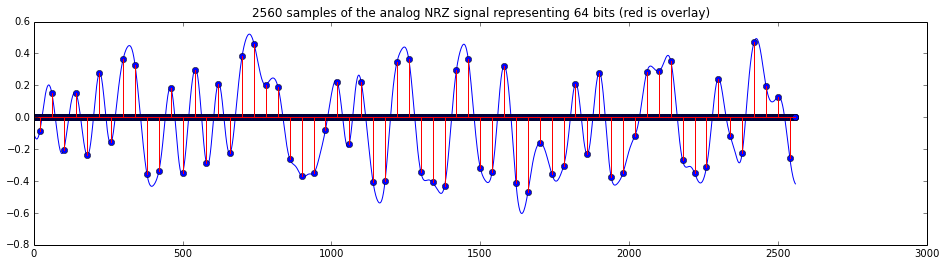

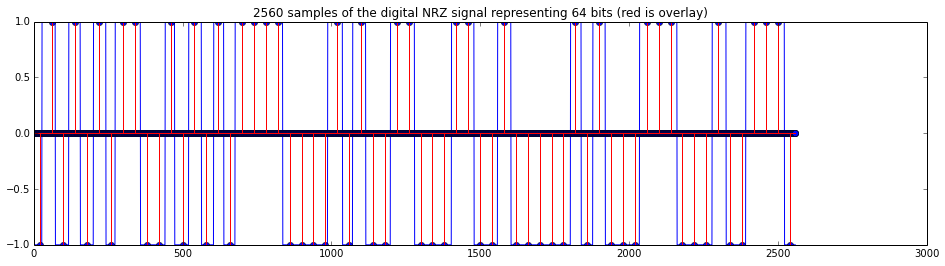

In [1481]:
# plot code
digital_NRZ = sign(demod_noisy_bits)
num_samples = 64

figure()
title('2560 samples of the analog NRZ signal representing 64 bits (red is overlay)')
plot(demod_noisy_bits[:num_samples*int(fs/baud)])
overlay = np.zeros(len(digital_NRZ))[:num_samples*int(fs/baud)]
overlay[int((fs/baud)/2)::int(fs/baud)] = demod_noisy_bits[int((fs/baud)/2):int(fs/baud)*num_samples][::int(fs/baud)]
stem(overlay, 'r')

figure()
title('2560 samples of the digital NRZ signal representing 64 bits (red is overlay)')
plot(digital_NRZ[:num_samples*int(fs/baud)])
overlay = np.zeros(len(digital_NRZ))[:num_samples*int(fs/baud)]
overlay[int((fs/baud)/2)::int(fs/baud)] = digital_NRZ[int((fs/baud)/2):int(fs/baud)*num_samples][::int(fs/baud)]
stem(overlay, 'r')

In [1482]:
# Calculate BER
ber = BER(bits_dec, bitstream)
print('[BER] Error across ALL bits:',ber)

('[BER] Error across ALL bits:', 0.0016000000000000001)


Your bit error rate should be around 0.0014 will depend also on the quality of the reconstruction. You can try to repeat the experiment for different choices of filters if you like. 

### Computing BER curves

BER curves are usually displayed in log log of the BER vs SNR. SNR is measured by energy per bit over noise power spectral density.
Since we are just interested in the trend, we will plot the BER vs 1/noise standard deviation. 

To help you debug your code, we generated our own curves and saved the results. Your results should be similar to ours. 

#### Task 8:

* Repeat the experiment for the range $\sigma=[0.1:8.0:0.1]$  
* Use the function loglog to plot the BER as a function of 1/$\sigma$. What's the BER at really low-SNR? What does it mean about the information the channel is carrying in low-SNR?

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


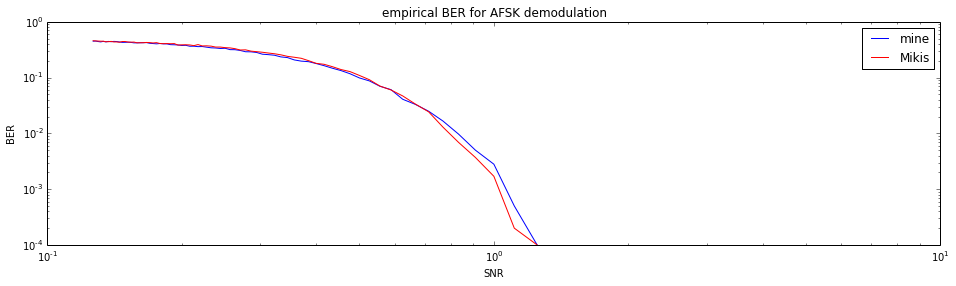

In [1468]:
### Load our simulation result:
# Load the file from the class website
testfile = urllib.URLopener()
testfile.context = ssl._create_unverified_context()
testfile.retrieve("https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab5/BER.npz", 'BER_ref.npz')
testnpz = np.load('BER_ref.npz')
BER_ref = testnpz['BER']

# Your code:

# Initialize variables
fs, TBW, baud, num_bits = 48e3, 2.0, 1200, 1e4

sigmas = r_[0.1:8.0:0.1]
BER_nc = []

for sigma in sigmas:
    
    # Generate random bits
    bitstream = bitarray.bitarray((np.random.randn(num_bits)>0).tolist())

    # AFSK1200 modulate
    afsk_bits = afsk1200(bitstream, fs=fs)

    # Add noise. Demodulate noisy bits
    noisy_afsk_bits = afsk_bits + sigma*np.random.randn(len(afsk_bits))
    demod_noisy_bits = nc_afsk1200Demod(noisy_afsk_bits, fs=fs, TBW=TBW) # analog output

    # Decode: calculate NRZ
    bits_dec = decode_NRZ(demod_noisy_bits)

    # Calculate BER
    ber = BER(bits_dec, bitstream)
    BER_nc += [ber]

# plot
c = len(sigmas)
loglog(1/(r_[0.1:8.0:0.1]),BER_nc[:c])
loglog(1/(r_[0.1:8.0:0.1]),BER_ref[:c],'r')

plt.legend(('mine','Miki''s'))

title("empirical BER for AFSK demodulation")
xlabel("SNR")
ylabel("BER")

np.savez_compressed('BER.npz', BER=BER_nc)

### Timing Recovery

One of the most important part of digital demodulation is the synchronization between the transmitter and receiver. We would like to sample the NRZ signal at the peak, which happens in the middle of the bit interval. However, we don't necessarily know when the transmitter starts sending the bits. There could also be some offset with the bit-rate between the transmitter and receiver due to the different clocks in the systems

There are many ways to do this. For example, if there's a known preamble sequence we could look for, we can perform a match filtering with the known sequence to find the bit rate and synchronize to its start. 

Here we will use a simple, yet elegant solution, that was implemented in DireWolf, which uses a counter based phased-lock-loop (PLL). Here's a system diagram for the timing recovery (D is a sample delay):

<center><img src="https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab5/PLL.png" alt="PLL" style="width: 550px;"/></center>
<center>Figure 4: Timing Recovery</center>

The idea is simple. For each incoming sample we advance a **32bit signed counter** by $2^{32}/(f_s/baud)$. The counter will overflow exactly every $fs/baud$ samples, which is the number of bits per symbol. When overflow happens, we record the sign of the NRZ signal and output it. **If the counter is synchronized to the NRZ signal, whenever there's a zero-crossing of the NRZ signal due to bit-sign change there also should be a zero-crossing of the counter and the counter should overflow in the middle of a symbol.**

## Note to self.

## Why this is true: 
** The *SIGNED* bit counter will switch sign halfway through a symbol because it goes through one full cycle (0 -> (+) max -> (-) max -> 0) every bit period samples = fs * (1/baud) where baud = bitrate [bits/s]. This is because we increment the pointer by 2^32/(fs/baud) for each sample. So halfway through a bit period, the counter will be 0, i.e., switching sign from positive to negative.**

So, in order to synchronize the PLL counter to the NRZ signal, whenever the NRZ signal has a zero-crossing, we will "nudge" the counter by multiplying it with $0<a<1$ to get it closer to zero. When the PLL is locked, the zero-crossings would match and the "nudging" would do nothing. When the PLL is not locked, then "nudging" would move the counter towards the right offset. This solution relies on the data not to have long sequences of the same bit value! As we will see later, APRS (and its underliying protocol AX.25) solved this by injecting bit transitions in a process called "bit stuffing". Also, before each packet, it is common to send a string of alternating values for helping receiver synchronization. 

The value of $a$ is of course a tradeoff. When $a$ is small, the PLL will lock fast, but would be sensitive to jitter due to noise. In that case, whenever the NRZ signal would have a zero-crossing the PLL would nudge a lot, and therefore be sensitive to noise as well.  When $a$ is closer to 1, the PLL will have less jitter, but would take more time to lock.  A value of $a=0.75$ seems to work well, to balance these two. 

#### Task 9:

Write a function `idx = PLL(NRZa, a, fs = fs, baud=baud)`. 

The function should take as input a segment of an "analog" NRZ sequence, the "nudge" factor $a$, the sampling rate and the baud rate. It should return the indexes corresponding to the middle sampling points of symbols.

* Python types don't allow for overflow, so when incrementing the counter, cast it to `int32`, to force overflow. 

In [1633]:
def PLL(NRZa, a = 0.74 , fs = 48000, baud = 1200):
    # 
    # function implements a simple phase-locked loop for timing recovery
    # Inputs:
    #          NRZa -   The **ANALOG** NRZ signal
    #          a - nudge factor
    #          fs - sampling rate (arbitrary)
    #          baud  - the bit rate
    #
    # Outputs:
    #          idx - array of indexes to sample at
    #
    #    np.int32(2**31-1+1) useful
    # Your code here

    counter, increment = 0, 2**32/(fs/baud)
    
    idx = []
    for i in range(len(NRZa)-1):  
        
        if sign(np.int32(counter + increment))  == -1 and sign(np.int32(counter)) == 1: # counter overflow, so sample!
            idx += [i]
            
        if sign((NRZa[i])) == 1 and sign(NRZa[i+1]) == -1:
            counter = np.int32(counter*a)
            
        counter = np.int32(counter + increment)
        
    return np.array(idx)

The following code generates 4 packets of length 24. Each packet consistes of  1,0,1,0,1,0 training sequence followed by 18 bits. It also puts random spacings between packets as well as noise.

To help you debug, we generated this packets, modulated, demodulated and computed the timing using our own implementation of the PLL.  You can use our data to see if your timings are correct. 

#### Task 10:
* Run your PLL and this data with a=0.75
* Plot the NRZa signal and overlay the sampling points that were returned by the PLL. Make sure the PLL works! You should see that the PLL will lock within very few bit lengths

** Note that for our data, on the 2nd and 4th packets, the PLL takes 5 bit lengths to lock **


In [ ]:
#bits=bitarray.bitarray([True,False,True,False,True, False]+(np.random.randn(24)>0).tolist())
#sig = zeros(int32(np.random.rand(1)*200+200))
#sig = concatenate((sig,afsk1200(bits, fs=48000)))

#for n in range(0,3):
#    bits=bitarray.bitarray([True,False,True,False, True, False]+(np.random.randn(18)>0).tolist())
#    sig = concatenate((sig,zeros(int32(np.random.rand(1)*200+200)),afsk1200(bits, fs=48000)))
#sig = sig + 0.1*np.random.randn(len(sig))
#NRZ = nc_afsk1200Demod(sig, fs=48000, baud =1200)
#idx  = PLL(NRZ, a=0.75)
#np.savez_compressed('debug_pll1.npz', idx=idx, sig = sig, bits = bits, NRZ=NRZ)

<Container object of 3 artists>

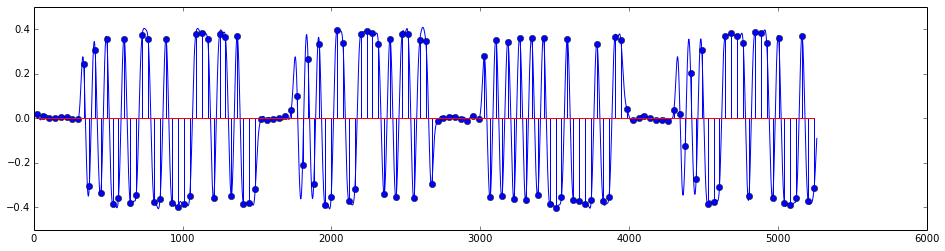

In [1618]:
# Load the file from the class website
testfile = urllib.URLopener()
testfile.context = ssl._create_unverified_context()
testfile.retrieve("https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab5/debug_pll1.npz", 'debug_pll1.npz')
testnpz = np.load('debug_pll1.npz')
_bits = testnpz['bits']
_sig = testnpz['sig']
_idx = testnpz['idx']
_NRZ = testnpz['NRZ']

figure
plot(_NRZ)
stem(_idx,_NRZ[_idx.astype(int)])

In [1629]:
_idx

array([   22.,    64.,   104.,   142.,   182.,   222.,   259.,   299.,
         335.,   373.,   412.,   450.,   490.,   529.,   569.,   609.,
         648.,   688.,   728.,   768.,   808.,   848.,   888.,   928.,
         968.,  1008.,  1048.,  1088.,  1128.,  1168.,  1208.,  1248.,
        1288.,  1328.,  1368.,  1408.,  1448.,  1488.,  1528.,  1567.,
        1606.,  1645.,  1686.,  1730.,  1770.,  1806.,  1843.,  1881.,
        1919.,  1958.,  1998.,  2037.,  2077.,  2117.,  2157.,  2196.,
        2236.,  2276.,  2316.,  2355.,  2395.,  2435.,  2475.,  2515.,
        2555.,  2594.,  2634.,  2674.,  2714.,  2752.,  2790.,  2830.,
        2873.,  2912.,  2952.,  2991.,  3027.,  3067.,  3107.,  3146.,
        3186.,  3226.,  3266.,  3306.,  3346.,  3386.,  3426.,  3466.,
        3506.,  3546.,  3586.,  3626.,  3666.,  3706.,  3746.,  3785.,
        3825.,  3865.,  3905.,  3945.,  3985.,  4025.,  4065.,  4100.,
        4140.,  4179.,  4219.,  4259.,  4302.,  4342.,  4378.,  4414.,
      

In [1628]:
idx

array([  48,   79,  125,  156,  196,  235,  275,  311,  360,  397,  444,
        480,  526,  566,  611,  645,  685,  720,  760,  797,  837,  875,
        923,  963, 1003, 1043, 1089, 1129, 1169, 1204, 1249, 1289, 1333,
       1366, 1411, 1451, 1491, 1531, 1586, 1617, 1665, 1699, 1745, 1782,
       1830, 1866, 1913, 1948, 1988, 2024, 2064, 2101, 2141, 2179, 2219,
       2259, 2299, 2338, 2386, 2423, 2470, 2510, 2556, 2590, 2630, 2666,
       2706, 2741, 2792, 2832, 2889, 2922, 2963, 3034, 3067, 3111, 3144,
       3189, 3223, 3268, 3302, 3347, 3381, 3427, 3461, 3501, 3541, 3587,
       3621, 3661, 3701, 3741, 3777, 3823, 3863, 3908, 3948, 3988, 4022,
       4062, 4093, 4133, 4168, 4208, 4244, 4284, 4316, 4362, 4397, 4443,
       4478, 4524, 4564, 4604, 4639, 4679, 4719, 4759, 4795, 4842, 4882,
       4922, 4957, 5003, 5038, 5078, 5118, 5164, 5199, 5239])

<Container object of 3 artists>

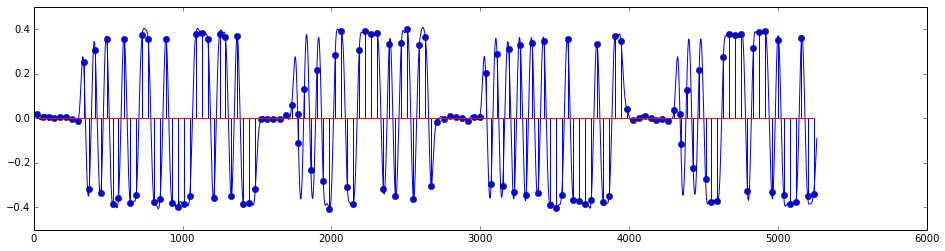

In [1634]:
# Run your PLL on the NRZ and compare the idx you get with ours. They should be similar.
# code for running your PLL:
idx  = PLL(_NRZ, a=0.75)
figure()
plot(_NRZ)
stem(idx,_NRZ[idx.astype(int)])

In [1635]:
idx

array([  20,   59,   99,  135,  175,  215,  254,  294,  334,  372,  412,
        450,  490,  529,  569,  609,  648,  688,  728,  768,  808,  848,
        888,  928,  968, 1008, 1048, 1088, 1128, 1168, 1208, 1248, 1288,
       1328, 1368, 1408, 1448, 1488, 1528, 1569, 1610, 1655, 1695, 1733,
       1773, 1778, 1818, 1862, 1902, 1945, 1985, 2025, 2065, 2107, 2147,
       2187, 2227, 2267, 2307, 2349, 2389, 2430, 2470, 2510, 2551, 2591,
       2631, 2672, 2712, 2757, 2797, 2837, 2878, 2918, 2958, 2996, 3036,
       3073, 3113, 3151, 3191, 3230, 3270, 3309, 3349, 3388, 3428, 3467,
       3507, 3547, 3587, 3626, 3666, 3706, 3746, 3786, 3826, 3866, 3906,
       3946, 3986, 4025, 4065, 4105, 4145, 4182, 4222, 4262, 4302, 4342,
       4347, 4387, 4431, 4471, 4514, 4554, 4594, 4634, 4674, 4714, 4754,
       4796, 4836, 4876, 4916, 4958, 4998, 5039, 5079, 5119, 5159, 5200,
       5240])

### Timing Jitter

Let's see the effect of the PLL nudging factor `a` on the timing jitter. 

#### Task 11:
* Generate a sequence of 1000 random bits
* Add random gaussian noise with standard deviation of 1
* Modulate the signal using AFSK1200
* Add 7 zero samples in the begining so the PLL will need to lock.

Even though there's noise, the best sampling timing is every 40 samples ( fs=48000 ), because that's the original rate. If our PLL is insensitive to noise, then it should give us the right value all the time.

* Used the PLL with $a=0.95$, to compute the indices of sampling points. Then, compute the finite difference in the indexes. Ideally, it should be 40 all the time.
* Repeat the above for $a=0.75$, and $a=0.4$


In [1624]:
diff?

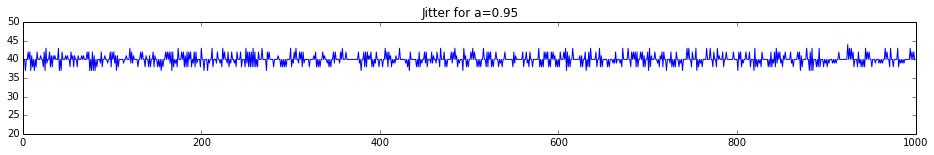

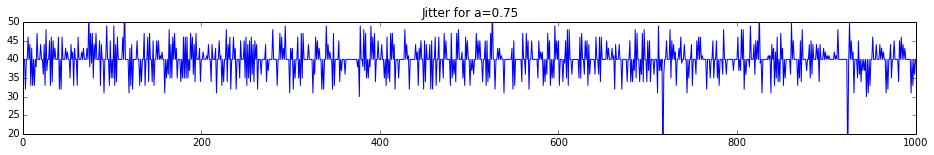

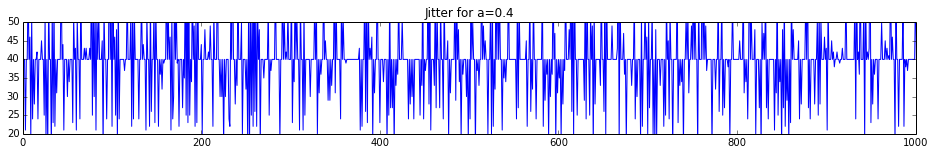

In [1622]:
# You get Task 11 for free!

bits=bitarray.bitarray((np.random.randn(1000)>0).tolist())
sig = afsk1200(bits, fs=48000)
sig = sig + np.random.randn(len(sig))*1
sig=np.concatenate((zeros(10),sig))
NRZ = nc_afsk1200Demod(sig, fs=48000)
idx1 = PLL(NRZ, a=0.9)
idx2 = PLL(NRZ, a=0.75)
idx3 = PLL(NRZ, a=0.4)

fig = plt.figure(figsize=(16,2))
plot(diff(idx1))
title('Jitter for a=0.95')
axis((0,1000,20,50))
fig2 = plt.figure(figsize=(16,2))
plot(diff(idx2))
axis((0,1000,20,50))
title('Jitter for a=0.75')
fig3 = plt.figure(figsize=(16,2))
plot(diff(idx3))
axis((0,1000,20,50))
title('Jitter for a=0.4')

- Can you see that for a=0.4 the Jitter is significant?



Now, you are ready to move to the data-link layer